In [1]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

In [2]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [3]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u

In [4]:
from astropy.table import Table, vstack, unique

ms_sdss4_wd_sdss4 = Table.read('data/ms_sdss4_wd_sdss4.fits')
ms_gaia_wd_sdss4 = Table.read('data/ms_gaia_wd_sdss4.fits')
ms_sdss5_wd_sdss4 = Table.read('sdss5/ms_sdss5_wd_sdss4.fits')

ms_gaia_wd_sdss5 = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
ms_sdss4_wd_sdss5 = Table.read('sdss5/ms_sdss4_wd_sdss5.fits')
ms_sdss5_wd_sdss5 = Table.read('sdss5/ms_sdss5_wd_sdss5.fits')

ms_gaia_wd_falcon = Table.read('data/ms_gaia_wd_falcon.fits')
gemini = Table.read('data/gemini.fits')


def strip(catalog):  
    drop_cols = []
    keep_cols = ['wd_source_id', 'ms_source_id', 'wd_l', 'wd_b', 'ms_parallax', 'ms_parallax_over_error', 'wd_ra', 'wd_dec', 
                 'wd_bp_rp', 'uses_sdss5']
        
    for key in catalog.keys():
        if key not in keep_cols:
            drop_cols.append(key)
            
    catalog.remove_columns(drop_cols)
    
    return catalog

ms_gaia_wd_sdss4  = strip(ms_gaia_wd_sdss4 )
ms_sdss4_wd_sdss4 = strip(ms_sdss4_wd_sdss4)
ms_sdss5_wd_sdss4 = strip(ms_sdss5_wd_sdss4)

ms_gaia_wd_sdss5  = strip(ms_gaia_wd_sdss5 )
ms_sdss4_wd_sdss5 = strip(ms_sdss4_wd_sdss5)
ms_sdss5_wd_sdss5 = strip(ms_sdss5_wd_sdss5)

gemini_1 = gemini.copy()

ms_gaia_wd_falcon = strip(ms_gaia_wd_falcon)
gemini = strip(gemini)

catalog = unique(vstack([ms_sdss4_wd_sdss4, ms_gaia_wd_sdss4, ms_sdss4_wd_sdss5, ms_sdss5_wd_sdss4, ms_gaia_wd_sdss5, ms_sdss5_wd_sdss5, ms_gaia_wd_falcon, gemini]), keys = 'wd_source_id')

In [5]:
print(catalog)

    ms_source_id        wd_source_id       ms_parallax     ...        wd_l                wd_b        uses_sdss5
------------------- ------------------- ------------------ ... ------------------ ------------------- ----------
  78630547564037504   78630783787018624  4.940878714239059 ... 146.06606747397458  -43.94621045934461        0.0
  90243761175084672   90244375354955392   4.90088696273875 ... 144.70900584705583  -44.60031645677885        0.0
  91690164426524288   91690164426711040 11.277563983542722 ... 141.56798220692895 -42.932042516885794        0.0
 235840678609579904  235840781689958016  2.858879969576937 ... 150.81419433264188 -15.142418794667933        0.0
 290678443086494848  290678477446232960 16.375135959740227 ...  138.6714454811497  -37.92124428204657        0.0
 299817274499164416  299817270203790464 3.9530250489405656 ...  141.5262993511704 -31.650726348757026        0.0
 300721519733864192  300721515441972608  5.465735127698064 ... 140.00211908900982 -31.2616509149

In [6]:
from astropy.table import Table, vstack, hstack

only_rvs = True

stardats = []
iters = (len(catalog)+100) // 100

# MS Gaia Sources

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['ms_source_id'][100*i:100*i+100]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)
gaia_d1.rename_column('source_id', 'ms_source_id')
catalog = join(catalog, gaia_d1, keys = 'ms_source_id')

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.30it/s]


In [7]:
catalog.remove_column('ms_source_id')

In [8]:
stardats = []
iters = (len(catalog)+100) // 100

# This query is for making sure the radii issue isn't a problem with the photometry from the El-Badry catalog (it's not)
for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT source_id, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_flux, phot_bp_mean_flux, phot_rp_mean_flux,
                 phot_g_mean_flux_error, phot_bp_mean_flux_error, phot_rp_mean_flux_error
        FROM gaiadr3.gaia_source     
        WHERE source_id in {}""".format(tuple(catalog['wd_source_id'][100*i:100*i+100]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)

for key in gaia_d1.keys():
    gaia_d1.rename_column(key, 'wd_' + key)
    
catalog = join(catalog, gaia_d1, keys = 'wd_source_id')

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


In [9]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarWebQuery

import pyphot
import extinction

# Coordinates using Bailer-Jones distances
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Bayestar2019 to get E(B-V) in arbitrary units
bsq = BayestarWebQuery()
bsq_res = bsq.query(catalog['wd_coords'], mode='samples')

# Convert to actual units
Ebv = np.median(bsq_res, axis=1)*0.901*0.98
Ebv_mean = np.mean(bsq_res, axis = 1)*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv_mean
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['BP_ext'] = ext_all.T[0]
catalog['RP_ext'] = ext_all.T[1]

# Subtract out the extinction to find de-reddened magnitude
catalog['wd_phot_bp_mean_mag'] = catalog['wd_phot_bp_mean_mag'] - catalog['BP_ext'] * catalog['E(B-V)']
catalog['wd_phot_bp_mean_mag'] = catalog['wd_phot_bp_mean_mag'] - catalog['RP_ext'] * catalog['E(B-V)']

In [10]:
sigmaG_0 = 0.0027553202
sigmaGBP_0 = 0.0027901700
sigmaGRP_0 = 0.0037793818

catalog['e_wd_phot_g_mean_mag'] = np.sqrt((-2.5/np.log(10)*catalog['wd_phot_g_mean_flux_error']/catalog['wd_phot_g_mean_flux'])**2 + sigmaG_0**2)
catalog['e_wd_phot_bp_mean_mag'] = np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error']/catalog['wd_phot_bp_mean_flux'])**2 + sigmaGBP_0**2)
catalog['e_wd_phot_rp_mean_mag'] = np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error']/catalog['wd_phot_rp_mean_flux'])**2 + sigmaGRP_0**2)

In [11]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed_sdss = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr'])#, 'Si', 'Sz'])
fitsed_gaia = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['bp', 'rp'])#, 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr']
initialized with atm_type = H and bands = ['bp', 'rp']


In [12]:
from scipy.interpolate import RegularGridInterpolator

# Band selector: 
#    to fit with G, BP, RP, set `bands = ['g', 'bp', 'rp']`.
#    to fit with only BP, RP, set `bands = ['bp', 'rp']`

bands = ['bp', 'rp']

#test = Table.read('../WD_models/Montreal_atm_grid_2021/Table_DA', format='ascii')
#
#if len(bands) == 3:
#    test['mag'] = np.array([test['G3'], test['G3_BP'], test['G3_RP']]).T
#elif len(bands) == 2:
#    test['mag'] = np.array([test['G3_BP'], test['G3_RP']]).T
#
#for key in test.keys():
#    if key not in ['Teff', 'logg', 'mag']:
#        test.remove_column(key)
#    
#teffs = sorted(list(set(test['Teff'])))
#loggs = sorted(list(set(test['logg'])))
#
#if len(bands) == 3:
#    values = np.zeros((len(teffs), len(loggs), 3))
#elif len(bands) == 2:
#    values = np.zeros((len(teffs), len(loggs), 2))
#
#for i in tqdm(range(len(teffs))):
#    for j in range(len(loggs)):
#        try:
#            values[i,j] = test[np.all([test['Teff'] == teffs[i], test['logg'] == loggs[j]], axis = 0)]['mag'][0]
#        except:
#            if len(bands) == 3:
#                values[i,j] = np.array([0, 0, 0])
#            elif len(bands) == 2:
#                values[i,j] = np.array([0, 0])
#            
#model_sed = RegularGridInterpolator((teffs, loggs), values)

In [13]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 

def flux_to_mag(flux):
    return -2.5 * np.log10(flux) - 48.60
    
def get_model_flux_gaia(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed_gaia.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux_to_mag(flux)
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = (get_model_flux_gaia(params))

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare



In [14]:
def get_parameters_gaia(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'leastsq')
    
    #result.params.pretty_print()
        
    return result

In [15]:
gaia_results = []
gaia_results7 = []
gaia_results9 = []

e_results = []

drops = []

logg_vary = []

id_ = []

for i in tqdm(range(len(catalog))):
    
    
    if len(bands) == 3:
        obs_mag = np.array([catalog['wd_phot_g_mean_mag'][i], catalog['wd_phot_bp_mean_mag'][i], catalog['wd_phot_rp_mean_mag'][i]])
        e_obs_mag = np.array([catalog['e_wd_phot_g_mean_mag'][i], catalog['e_wd_phot_bp_mean_mag'][i], catalog['e_wd_phot_rp_mean_mag'][i]])
    elif len(bands) == 2:
        obs_mag = np.array([catalog['wd_phot_bp_mean_mag'][i], catalog['wd_phot_rp_mean_mag'][i]])
        e_obs_mag = np.array([catalog['e_wd_phot_bp_mean_mag'][i], catalog['e_wd_phot_rp_mean_mag'][i]])
        
    try:    
        gaia_logg7 = get_parameters_gaia( obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_med_geo'][i]] )
        gaia_logg8 = get_parameters_gaia( obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_med_geo'][i]] )
        gaia_logg9 = get_parameters_gaia( obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_med_geo'][i]] )
        id_.append(i)
        
        gaia_results.append(gaia_logg8)
        gaia_results7.append(gaia_logg7)
        gaia_results9.append(gaia_logg9)
    except:
        drops.append(i)
        
   

    
    fig = plt.figure(figsize = (8,7))
    
    plt.errorbar(bands, obs_mag, yerr = e_obs_mag, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED')
    plt.plot(bands, get_model_flux_gaia(gaia_logg8.params), 'bo', markersize = 10, label = 'Model SED')
    
    plt.title('SED {}'.format(i))
    
    plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(gaia_logg8.params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.20, r'$logg = ${} '.format(gaia_logg8.params['logg'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.15, r'$dist = ${} $pc$'.format(gaia_logg8.params['distance'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.36, r'$bp-rp = ${}'.format(catalog['wd_bp_rp'][i]), transform = plt.gca().transAxes, fontsize=20)
    
    plt.xlabel('Band')
    plt.ylabel('Apparent Flux)')
    
    plt.gca().invert_yaxis()
    plt.legend() 
    plt.savefig('spectra/leastsq/phot_fit/{}.png'.format(i))
    plt.close()
    
print('dropped {} stars'.format(len(drops)))
catalog.remove_rows(drops)
catalog['wd_catalog_id_phot'] = id_
results = gaia_results

100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [01:42<00:00,  5.96it/s]

dropped 3 stars


In [16]:
len(results)

610

In [17]:
catalog['raw_radius_result'] = [result for result in gaia_results]
catalog['radius'] = [result.params['radius'].value for result in gaia_results]
catalog['phot_teff'] = [result.params['teff'].value for result in gaia_results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in gaia_results]
catalog['redchi'] = [result.redchi for result in gaia_results]
catalog['e_radius'] = [np.sqrt(gaia_results[i].params['radius'].stderr**2 + np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value)**2 ) for i in range(len(gaia_results))]
catalog['error_from_model'] = [np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value) for i in range(len(gaia_results))]

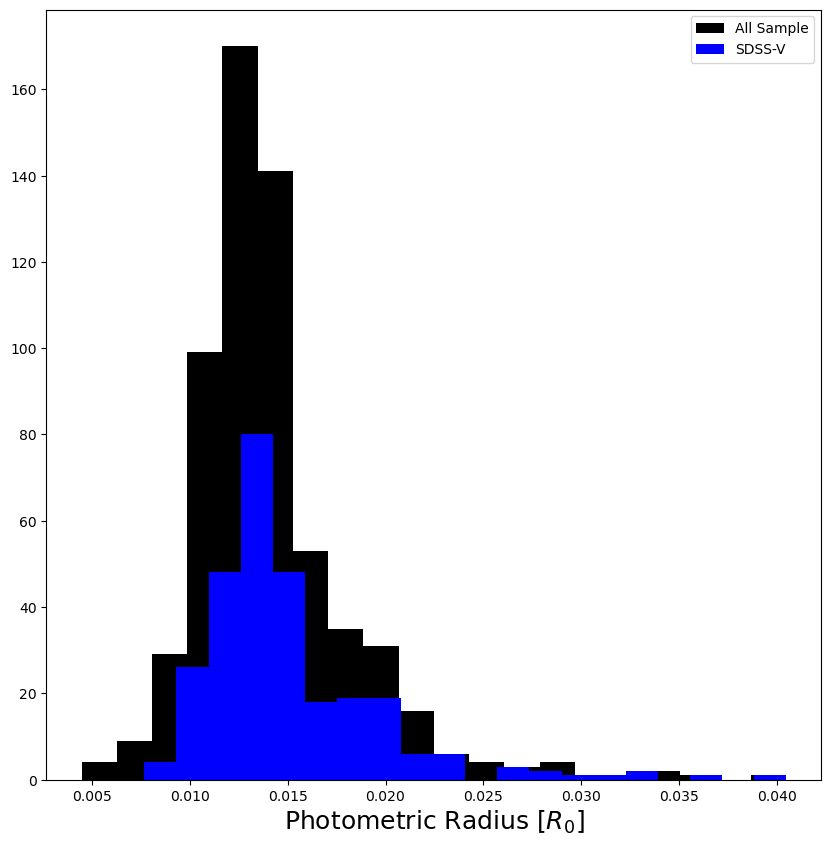

In [18]:
plt.figure(figsize=(10,10))
plt.hist(catalog['radius'], bins = 20, color='black', label = 'All Sample')
plt.hist(catalog['radius'][catalog['uses_sdss5'] == 1], bins = 20, color='blue', label = 'SDSS-V')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.legend()

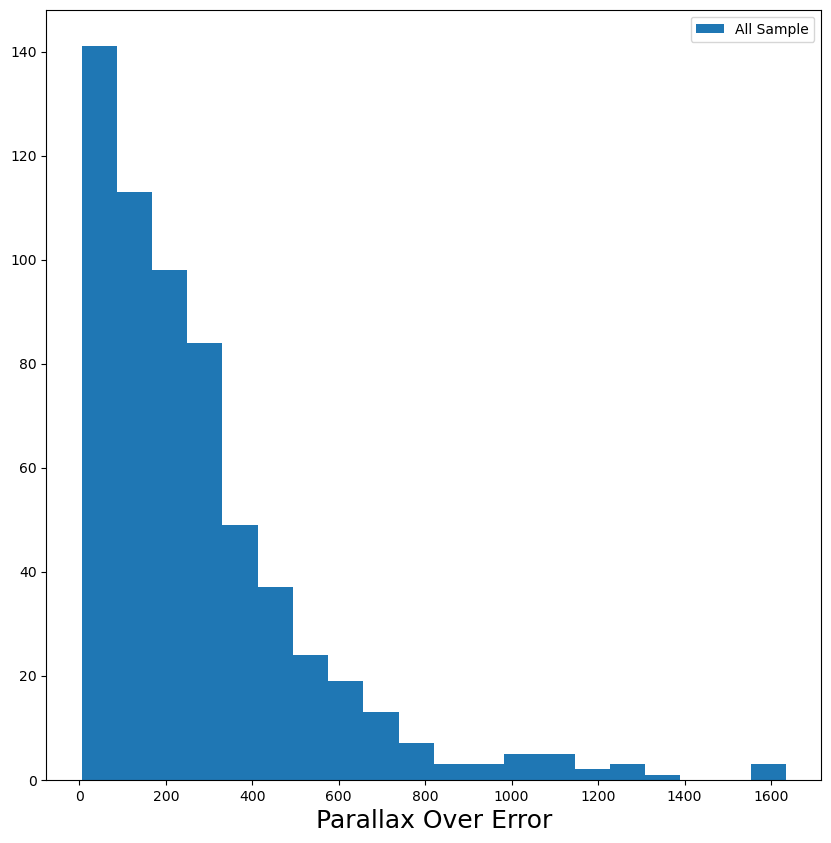

In [19]:
plt.figure(figsize=(10,10))
plt.hist(catalog['ms_parallax_over_error'], bins = 20, label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Parallax Over Error', fontsize=18)
plt.legend()

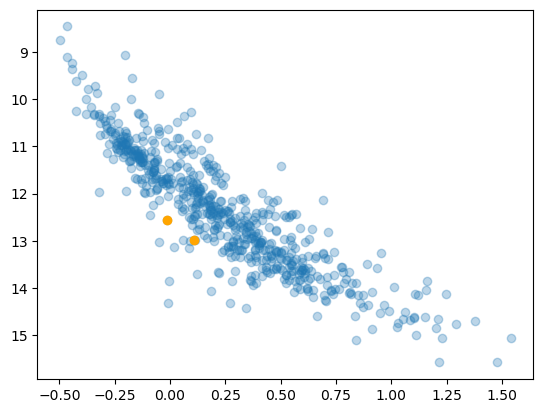

In [20]:
plt.scatter(catalog['wd_bp_rp'], catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100), alpha = 0.3) 
plt.scatter(gemini_1['wd_bp_rp'], 
            gemini_1['wd_phot_g_mean_mag'] + 5 * np.log10(gemini_1['ms_parallax'] / 100), color = 'orange') 
plt.gca().invert_yaxis()


In [21]:
# Gemini object no.1
catalog[catalog['wd_source_id'] == 3053811568108421504]

wd_source_id,ms_parallax,ms_parallax_over_error,wd_bp_rp,wd_ra,wd_dec,wd_l,wd_b,uses_sdss5,r_med_geo,wd_phot_g_mean_mag,wd_phot_bp_mean_mag,wd_phot_rp_mean_mag,wd_phot_g_mean_flux,wd_phot_bp_mean_flux,wd_phot_rp_mean_flux,wd_phot_g_mean_flux_error,wd_phot_bp_mean_flux_error,wd_phot_rp_mean_flux_error,wd_coords,E(B-V),e_E(B-V),A_v0,BP_ext,RP_ext,e_wd_phot_g_mean_mag,e_wd_phot_bp_mean_mag,e_wd_phot_rp_mean_mag,wd_catalog_id_phot,raw_radius_result,radius,phot_teff,e_phot_teff,redchi,e_radius,error_from_model
,,,,,,,,,pc,mag,mag,mag,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,"deg,deg,pc",,,,,,electron / s,electron / s,electron / s,,,,,,,,
int64,float64,float32,float32,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64,float32,float32,float32,SkyCoord,float32,float32,float32,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64
3053811568108421504,8.814823841102658,562.90454,0.110105515,111.21333342851565,-8.435096265944722,224.26130255913728,3.4981603272489012,--,113.09885,18.26406,16.315458297729492,16.205353,931.8011810065932,4066.6181639998103,2612.2637151541453,1.6418608,504.16125,226.58652,"224.26130255913728,3.4981603272489012,113.09884643554688",0.0,0.0,0.0,0.0,0.0,0.0033543607950204074,0.13463366189926163,0.0942520421896621,427,<lmfit.minimizer.MinimizerResult object at 0x7f73ed178760>,0.021462266126133344,10019.685788948027,3.2120773707679294e-06,2.382635094085426e-30,0.0006105559678665325,0.0006105559678665322


In [22]:
# Gemini object no.2
catalog[catalog['wd_source_id'] == 3630648387747801088]

wd_source_id,ms_parallax,ms_parallax_over_error,wd_bp_rp,wd_ra,wd_dec,wd_l,wd_b,uses_sdss5,r_med_geo,wd_phot_g_mean_mag,wd_phot_bp_mean_mag,wd_phot_rp_mean_mag,wd_phot_g_mean_flux,wd_phot_bp_mean_flux,wd_phot_rp_mean_flux,wd_phot_g_mean_flux_error,wd_phot_bp_mean_flux_error,wd_phot_rp_mean_flux_error,wd_coords,E(B-V),e_E(B-V),A_v0,BP_ext,RP_ext,e_wd_phot_g_mean_mag,e_wd_phot_bp_mean_mag,e_wd_phot_rp_mean_mag,wd_catalog_id_phot,raw_radius_result,radius,phot_teff,e_phot_teff,redchi,e_radius,error_from_model
,,,,,,,,,pc,mag,mag,mag,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,"deg,deg,pc",,,,,,electron / s,electron / s,electron / s,,,,,,,,
int64,float64,float32,float32,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64,float32,float32,float32,SkyCoord,float32,float32,float32,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64
3630648387747801088,17.712380230989538,1013.46893,-0.013959885,204.91582815570885,-7.221270578957777,323.43072229719735,53.72009508912655,--,56.286514,16.32448,16.32703399658203,16.340994,5561.025933695923,4023.493468614833,2305.476418167508,4.075968,13.082261,9.632535,"323.43072229719735,53.72009508912655,56.28651428222656",0.0,0.0,0.0,0.0,0.0,0.0028679393139862557,0.004499735488940617,0.00590440299664158,465,<lmfit.minimizer.MinimizerResult object at 0x7f73ec23f760>,0.008782818447432979,11485.638629764,0.00031397469648895723,1.8077638976070228e-24,0.0006196808463064214,0.0006196808463063957


In [23]:
catalog.remove_columns(['ms_parallax', 'wd_l', 'wd_b', 'raw_radius_result', 'wd_bp_rp', 'wd_phot_g_mean_mag', 'e_phot_teff',
                        'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'wd_phot_g_mean_flux_error', 'wd_phot_bp_mean_flux_error', 'wd_phot_rp_mean_flux_error'])

In [24]:
catalog.write('data/02_photometry.fits', overwrite=True)

In [25]:
nug = catalog[['wd_source_id', 'phot_teff']]
nug.pprint()

nug.write('data/nugget.fits', overwrite = True)

    wd_source_id        phot_teff     
------------------- ------------------
  78630783787018624  7458.434097868265
  90244375354955392  9268.413863620646
  91690164426711040 15558.478744540218
 235840781689958016 16369.693640751882
 290678477446232960 8113.1007455749905
 299817270203790464  7974.519232149502
 300721515441972608  7312.397598205373
 361278458368372992  6655.810210487427
 520790043346964608   12502.0696023584
 545940164944375296  7356.894194975239
                ...                ...
6339275452909996544  5745.295555698465
6886973535081311872 11273.344243520009
6898255177217741952    9979.6355961375
6898705800892401280 12164.890201683644
6899127085644261632 13434.405490048197
6899212229075129344 13768.117578730475
6908407066861225728  7510.530663018256
6910805342238827648 19360.760784037535
6915121784373453184  8510.135478214928
6915495141583341824   9912.29705760775
Length = 610 rows
